# 4.1 Evaluating a Classifier on MS COCO

In [1]:
!pip3 install shapely tqdm torchmetrics torchnet torch==1.10.0+cu113 torchvision==0.11.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [2]:
# Variables
phase = "val"
root = "ML_GCN/data/coco/"

# Tunable parameter
batch_size = 128
num_workers = 6

# Constants (do not change)
num_classes = 80
input_size = 448

# Restore model and infer on valdiation set

### Restore model

In [3]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "ML_GCN"))

import torch
from models import gcn_resnet101


model = gcn_resnet101(num_classes=num_classes, t=0.4, pretrained=False, adj_file=f"{root}coco_adj.pkl")
model.load_state_dict(torch.load("ML_GCN/checkpoint/coco/coco_checkpoint.pth.tar")["state_dict"])
model.cuda()
model.eval()

GCNResnet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

### Get data, create dataset and dataloader

In [4]:
from coco import COCO2014
from util import Warp
import torchvision.transforms as transforms


val_dataset = COCO2014(root, phase=phase, inp_name=f"{root}coco_glove_word2vec.pkl")

normalize = transforms.Normalize(mean=model.image_normalization_mean,
                                 std=model.image_normalization_std)
val_dataset.transform = transforms.Compose([
                Warp(input_size),
                transforms.ToTensor(),
                normalize,
            ])

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

[dataset] Done!
[annotation] Done!
[json] Done!


### Infer

In [5]:
from tqdm import tqdm


label_batch_collection = []
predi_batch_collection = []
file_name_collection = []

with torch.no_grad():
    for (input_, target) in tqdm(val_loader):
            
            feature_var = torch.autograd.Variable(input_[0]).float().cuda()
            inp_var = torch.autograd.Variable(input_[2]).float().detach().cuda()

            target[target == 0] = 1
            target[target == -1] = 0
            target_var = torch.autograd.Variable(target).float().cuda()

            output = model(feature_var, inp_var).round().clamp(0,1)
            
            label_batch_collection += [target_var.cpu().detach()]
            predi_batch_collection += [output.cpu().detach()]
            
            file_name_collection += [input_[1]]

100%|██████████| 314/314 [07:16<00:00,  1.39s/it]


In [6]:
import numpy as np


y_true = np.concatenate(label_batch_collection)
y_pred = np.concatenate(predi_batch_collection)
file_names = np.concatenate(file_name_collection)

### Small performance insight

In [7]:
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score


f1 = f1_score(y_true=y_true, y_pred=y_pred, average=None)
pr = precision_score(y_true=y_true, y_pred=y_pred, average=None)
re = recall_score(y_true=y_true, y_pred=y_pred, average=None)

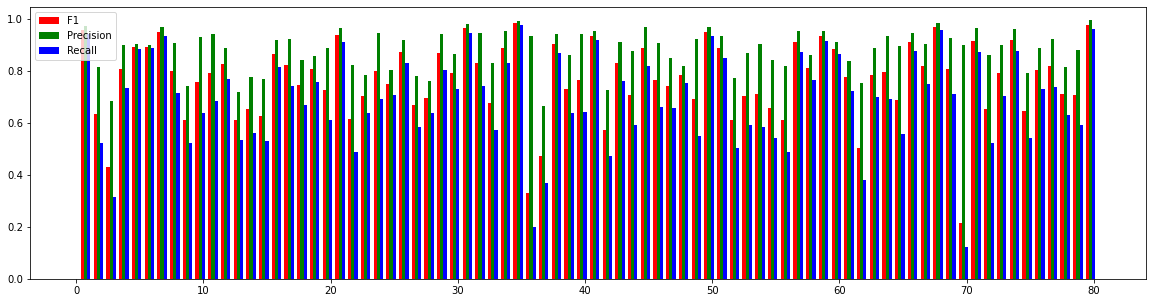

In [8]:
from matplotlib import pyplot as plt


fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(80) + 0.5, f1, 0.25, color="r", label="F1")
plt.bar(np.arange(80) + 0.75, pr, 0.25, color="g", label="Precision")
plt.bar(np.arange(80) + 1., re, 0.25, color="b", label="Recall")
plt.legend()
plt.show()

# Using the labels (segmentation masks) to define where the object is

In [9]:
import json


data = os.path.join(root, "data/")
annotations_data = os.path.join(data, "annotations")
annotations_file = json.load(open(os.path.join(annotations_data, f"instances_{phase}2014.json")))

### Lookup dictionaries (idx - MS COCO classes, idx - files, idx - image sizes)

In [10]:
import ast


# From: https://gist.github.com/SrikarNamburu/0945de8f9a8714ec245dde3443e9d487
#coco_classes = '''{1: "person", 2: "bicycle", 3: "car", 4: "motorcycle", 5: "airplane", 6: "bs", 7: "train", 8: "trck", 9: "boat", 10: "traffic light", 11: "fire hydrant", 12: "stop sign", 13: "parking meter", 14: "bench", 15: "bird", 16: "cat", 17: "dog", 18: "horse", 19: "sheep", 20: "cow", 21: "elephant", 22: "bear", 23: "zebra", 24: "giraffe", 25: "backpack", 26: "mbrella", 27: "handbag", 28: "tie", 29: "sitcase", 30: "frisbee", 31: "skis", 32: "snowboard", 33: "sports ball", 34: "kite", 35: "baseball bat", 36: "baseball glove", 37: "skateboard", 38: "srfboard", 39: "tennis racket", 40: "bottle", 41: "wine glass", 42: "cp", 43: "fork", 44: "knife", 45: "spoon", 46: "bowl", 47: "banana", 48: "apple", 49: "sandwich", 50: "orange", 51: "broccoli", 52: "carrot", 53: "hot dog", 54: "pizza", 55: "dont", 56: "cake", 57: "chair", 58: "coch", 59: "potted plant", 60: "bed", 61: "dining table", 62: "toilet", 63: "tv", 64: "laptop", 65: "mose", 66: "remote", 67: "keyboard", 68: "cell phone", 69: "microwave", 70: "oven", 71: "toaster", 72: "sink", 73: "refrigerator", 74: "book", 75: "clock", 76: "vase", 77: "scissors", 78: "teddy bear", 79: "hair drier", 80: "toothbrsh"}'''
#coco_classes = ast.literal_eval(dic)

# From COCO official (used below -- it's not the ML_GCN mapping)
coco_classes = dict(list(map(lambda x: (x["id"], x["name"]), annotations_file["categories"])))

# From the preparation script: ML_GCN/data/coco/data/category.json
reverse_classes = '''{"airplane": 0, "apple": 1, "backpack": 2, "banana": 3, "baseball bat": 4, "baseball glove": 5, "bear": 6, "bed": 7, "bench": 8, "bicycle": 9, "bird": 10, "boat": 11, "book": 12, "bottle": 13, "bowl": 14, "broccoli": 15, "bus": 16, "cake": 17, "car": 18, "carrot": 19, "cat": 20, "cell phone": 21, "chair": 22, "clock": 23, "couch": 24, "cow": 25, "cup": 26, "dining table": 27, "dog": 28, "donut": 29, "elephant": 30, "fire hydrant": 31, "fork": 32, "frisbee": 33, "giraffe": 34, "hair drier": 35, "handbag": 36, "horse": 37, "hot dog": 38, "keyboard": 39, "kite": 40, "knife": 41, "laptop": 42, "microwave": 43, "motorcycle": 44, "mouse": 45, "orange": 46, "oven": 47, "parking meter": 48, "person": 49, "pizza": 50, "potted plant": 51, "refrigerator": 52, "remote": 53, "sandwich": 54, "scissors": 55, "sheep": 56, "sink": 57, "skateboard": 58, "skis": 59, "snowboard": 60, "spoon": 61, "sports ball": 62, "stop sign": 63, "suitcase": 64, "surfboard": 65, "teddy bear": 66, "tennis racket": 67, "tie": 68, "toaster": 69, "toilet": 70, "toothbrush": 71, "traffic light": 72, "train": 73, "truck": 74, "tv": 75, "umbrella": 76, "vase": 77, "wine glass": 78, "zebra": 79}'''
reverse_classes = ast.literal_eval(reverse_classes)

# Some more dictionary mappings
file_mapping = dict(list(map(lambda x: (x["id"], x["file_name"]), annotations_file["images"])))
reverse_file_mapping = dict(list(map(lambda x: (x["file_name"], x["id"]), annotations_file["images"])))

image_size_mapping = dict(list(map(lambda x: (x["id"], [x["height"], x["width"]]), annotations_file["images"])))

# For each annotated object (except crowds), create entry with the necessary information
* direction of the center of mass from the center of the image
    --> "orientation"
* the vertical position
    --> "center_of_mass_x"
* the horizontal position
    --> "center_of_mass_y"
* object is in the right or left half
    --> "top", "bottom"
* object is in the top or bottom half
    --> "left", "right"

In [11]:
from shapely.geometry import Polygon as Poly
from shapely.geometry import MultiPolygon


show_image_id = None
#exclusive_positions = False # can be used if not only the centroid is considered

annotations = annotations_file["annotations"]
image_folder = os.path.join(data, f"{phase}2014")

if not show_image_id is None:
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection

    
    fig, ax = plt.subplots()
    patches = []
    classes = []

# iterate through all annotations
object_list = []
for i in tqdm(annotations):

    object_id = i["id"]
    image_id = i["image_id"]
    
    if not show_image_id is None:
        if image_id != show_image_id:
            continue 
    
    segmentation_mask = list(i["segmentation"])
    bbox_mask = list(i["bbox"])
    image_area = i["area"]
    category = i["category_id"]
    class_ = coco_classes[category]
    class_id = reverse_classes[class_]
    
    height, width = image_size_mapping[image_id]
    image_center = np.asarray([height/2, width/2])
    
    x, y, dx, dy = bbox_mask
    bbox_mask = [x, y, x+dx, y, x+dx, y+dy, x, y+dy]
    
    # if segmentation does not exist, fall back to bbox_mask
    # crowds are not supported
    if segmentation_mask == None:
        segmentation_mask = [bbox_mask]
        image_area = dx*dy
    elif i["iscrowd"]: # segmentation is ignored/skipped
        # Ignore crowds: https://github.com/AlexeyAB/darknet/issues/5567#issuecomment-626758944
        #segmentation_mask = [bbox_mask]
        continue
    
    """
    # NOTE: only holds for convex objects!
    # TODO: maybe use the polygon for comparison?
    flat_seg_mask = np.reshape(sum(segmentation_mask, []), (-1,2))
    top, bottom = [np.any(flat_seg_mask[:,0]<=image_center[0]), np.any(flat_seg_mask[:,0]>=image_center[0])]
    left, right = [np.any(flat_seg_mask[:,1]<=image_center[1]), np.any(flat_seg_mask[:,1]>=image_center[1])]
    if exclusive_positions and (top == bottom or left == right):
        continue
    """
    
    # get all polygons from this object annotation (same object, just not continuous)
    poly_list = []
    for segment in segmentation_mask:
        x_y_points = np.reshape(segment, (-1,2))

        # TODO: How is "combined center of mass" defined? --> weighted sum?
        poly_list.append(Poly(x_y_points))

        if not show_image_id is None:
            polygon = Polygon(x_y_points, True)
            patches.append(polygon)
            classes.append(class_)

    # calculate center of mass and find the quadrant
    center_of_mass = np.asarray(MultiPolygon(poly_list).centroid.coords)[0]
    top, bottom = [np.any(center_of_mass[0]<=image_center[0]), np.any(center_of_mass[0]>=image_center[0])]
    left, right = [np.any(center_of_mass[1]<=image_center[1]), np.any(center_of_mass[1]>=image_center[1])]

    # normalized orientation vector
    orientation = center_of_mass-image_center
    orientation /= np.linalg.norm(orientation)

    object_list.append({"image_id":image_id, "object_id":object_id, "class_id":class_id, "category":category, 
                        "image_area":image_area, "bbox_mask":bbox_mask, "segmentation_mask":segmentation_mask,
                        "orientation":orientation, "top":top, "bottom":bottom, "left":left, "right":right,
                        "center_of_mass_x":center_of_mass[0], "center_of_mass_y":center_of_mass[1],
                        "image_height":height, "image_width":width})

if not show_image_id is None:
    colors = 100 * np.random.rand(len(patches))
    p = PatchCollection(patches, alpha=0.7)
    p.set_array(colors)
    ax.add_collection(p)

    file_name = file_mapping[show_image_id]
    path = os.path.join(image_folder, file_name)
    image = plt.imread(path)
    
    ax.imshow(image)
    plt.plot([image_center[1]-100, image_center[1]+100], [image_center[0], image_center[0]], c="r", linewidth=2, linestyle="dashed")
    plt.plot([image_center[1], image_center[1]], [image_center[0]-100, image_center[0]+100], c="r", linewidth=2, linestyle="dashed")
    plt.title(", ".join(classes))
    plt.show()

100%|██████████| 291875/291875 [01:27<00:00, 3339.74it/s]


### Annotations df

In [12]:
import pandas as pd


df = pd.DataFrame(object_list)

### Calculate class image centroids ("If more than one instance of the object is present in the image, we calculate the combined center of mass")
* This takes some time

In [13]:
def calc_class_centroid(data):
    image_areas = data["image_area"]
    portion = image_areas/image_areas.sum()
    
    class_center_of_mass_x = data["center_of_mass_x"] * portion
    class_center_of_mass_y = data["center_of_mass_y"] * portion
    
    data["class_center_of_mass_x"] = class_center_of_mass_x.sum()
    data["class_center_of_mass_y"] = class_center_of_mass_y.sum()
    
    x_center = data["image_height"].mean()/2
    y_center = data["image_width"].mean()/2
    
    data["class_top"] = class_center_of_mass_x<=x_center
    data["class_bottom"] = class_center_of_mass_x>=x_center
    data["class_left"] = class_center_of_mass_y<=y_center
    data["class_right"] = class_center_of_mass_y>=y_center
    
    return data

df_class_centroids = df.groupby(["image_id", "class_id"]).apply(calc_class_centroid)
df_class_centroids

,image_id,object_id,class_id,category,image_area,bbox_mask,segmentation_mask,orientation,top,bottom,...,center_of_mass_x,center_of_mass_y,image_height,image_width,class_center_of_mass_x,class_center_of_mass_y,class_top,class_bottom,class_left,class_right
0,558840,156,38,58,2765.14865,"[199.84, 200.46, 277.55, 200.46, 277.55, 271.3...","[[239.97, 260.24, 222.04, 270.49, 199.84, 253....","[0.28043442078007047, -0.9598731872709783]",False,True,...,238.306659,235.091568,427,640,238.306659,235.091568,False,True,True,False
1,200365,509,38,58,1545.42130,"[234.22, 317.11, 383.61, 317.11, 383.61, 355.6...","[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...","[0.9836720564382092, 0.1799702347129234]",False,True,...,306.688344,332.201136,480,640,319.812154,365.556723,True,False,True,False
2,200365,603,38,58,5607.66135,"[239.48, 347.87, 399.48, 347.87, 399.48, 405.6...","[[274.58, 405.68, 298.32, 405.68, 302.45, 402....","[0.8283085635424705, 0.5602721870325253]",False,True,...,325.959283,378.143303,480,640,319.812154,365.556723,True,False,True,False
3,200365,918,38,58,0.00000,"[296.65, 388.33, 297.67999999999995, 388.33, 2...","[[296.65, 388.33, 296.65, 388.33, 297.68, 388....","[0.6416626709840216, 0.766986972943903]",False,True,...,297.165000,388.330000,480,640,319.812154,365.556723,True,False,True,False
4,200365,1072,38,58,800.41325,"[251.87, 333.42, 377.81, 333.42, 377.81, 356.1...","[[251.87, 356.13, 260.13, 343.74, 300.39, 335....","[0.9436293572059015, 0.33100398218024085]",False,True,...,302.084805,341.777955,480,640,319.812154,365.556723,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288410,301266,2231815,12,84,97.87435,"[235.52, 198.91, 242.04000000000002, 198.91, 2...","[[235.52, 199.51, 238.09, 226.59, 242.04, 225....","[-0.5871403278260027, -0.8094851669057155]",True,False,...,238.636126,213.126024,612,612,219.796539,212.310070,True,False,True,False
288411,354559,2231847,66,88,16455.53930,"[35.22, 2.25, 224.68, 2.25, 224.68, 268.34, 35...","[[83.51, 10.19, 66.39, 22.41, 59.06, 46.86, 53...","[-0.9658653240763068, -0.25904473696056957]",True,False,...,103.560064,110.724861,500,300,103.560064,110.724861,True,False,True,False
288412,88142,2231848,66,88,21389.27675,"[295.78, 162.67, 473.56999999999994, 162.67, 4...","[[320.92, 248.27, 308.95, 209.96, 314.34, 190....","[0.9998540188207663, 0.017086282450045828]",False,True,...,381.313731,253.670904,333,500,269.292087,165.339078,True,False,True,False
288413,88142,2231855,66,88,4411.33690,"[246.62, 45.18, 330.69, 45.18, 330.69, 143.32,...","[[272.58, 105.01, 269.48, 99.34, 255.73, 98.82...","[0.6271343754310136, -0.7789110829566829]",False,True,...,292.681746,93.280222,333,500,269.292087,165.339078,True,False,True,False


### Predictions per image as df

In [14]:
precision_table = ((y_true==1.0)&(y_true==y_pred)).astype(float)

df_classes = pd.DataFrame(np.hstack([file_names[...,np.newaxis], precision_table ]), columns=["file_names", *reverse_classes.keys()])
df_classes["image_id"] = df_classes.apply(lambda x: reverse_file_mapping[x["file_names"]], axis=1)
df_classes = df_classes.drop(columns=["file_names"])
df_classes

,airplane,apple,backpack,banana,baseball bat,baseball glove,bear,bed,bench,bicycle,...,toothbrush,traffic light,train,truck,tv,umbrella,vase,wine glass,zebra,image_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,391895
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,522418
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,184613
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318219
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,554625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134574
40133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,572233
40134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,418825
40135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,560744


### Inner merge on image_id's (each annotation gets all the predicted classes for that image)

In [15]:
merged = df_class_centroids.merge(df_classes, on="image_id")
merged = merged.dropna()
merged

,image_id,object_id,class_id,category,image_area,bbox_mask,segmentation_mask,orientation,top,bottom,...,toilet,toothbrush,traffic light,train,truck,tv,umbrella,vase,wine glass,zebra
0,558840,156,38,58,2765.14865,"[199.84, 200.46, 277.55, 200.46, 277.55, 271.3...","[[239.97, 260.24, 222.04, 270.49, 199.84, 253....","[0.28043442078007047, -0.9598731872709783]",False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,558840,370268,13,44,3193.20600,"[325.27, 104.38, 358.94, 104.38, 358.94, 210.3...","[[357.57, 210.37, 338.46, 209.92, 327.55, 204....","[0.621874221048099, -0.7831171388724806]",False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,558840,371514,13,44,1600.37325,"[168.85, 90.98, 200.26999999999998, 90.98, 200...","[[170.5, 171.44, 168.85, 149.95, 169.95, 138.3...","[-0.16080601837220662, -0.9869860305269156]",True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,558840,676791,26,47,4314.17925,"[1.92, 87.91, 36.870000000000005, 87.91, 36.87...","[[1.92, 263.26, 18.81, 256.85, 33.38, 249.28, ...","[-0.8230602497184428, -0.5679540697392832]",True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,558840,1246080,49,1,66127.95360,"[346.58, 1.07, 638.5899999999999, 1.07, 638.58...","[[346.58, 89.15, 387.75, 77.66, 425.09, 68.09,...","[0.8878105543852808, -0.460209104127787]",False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288410,133051,2204335,23,85,2752.92220,"[128.91, 423.4, 179.36, 423.4, 179.36, 499.559...","[[131.76, 451.96, 142.23, 437.68, 153.66, 428....","[-0.5983404110584818, 0.8012420061968586]",True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288411,261178,2204326,23,85,7458.84635,"[260.5, 158.2, 342.40999999999997, 158.2, 342....","[[261.84, 191.77, 291.38, 162.23, 311.52, 158....","[0.6498190553456968, -0.7600889390785962]",False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288412,261178,2204344,23,85,5105.56385,"[397.66, 112.06, 499.29, 112.06, 499.29, 202.8...","[[458.0, 202.89, 444.66, 195.26, 419.26, 181.9...","[0.8094849485308009, -0.5871406288974444]",False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288413,284282,2226144,27,67,46696.01900,"[64.13, 91.95, 499.09, 91.95, 499.09, 328.75, ...","[[64.13, 328.75, 92.91, 160.2, 92.09, 212.0, 1...","[0.9980812063525145, 0.06191853943617563]",False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### For each class and direction calculate accuracy 

In [16]:
def get_class_acc(data):
    column_names = list(reverse_classes.keys())
    column_id = int(data["class_id"].mean())
    data["acc"] = data[column_names[column_id]].astype("float").mean()
    data = data.drop(columns=column_names)
    return data

# either "class_" or "" as prefix
class_or_single_center = "class_"

horizontal_top = merged.groupby(["class_id", class_or_single_center+"top"]) \
    .apply(get_class_acc) \
    .groupby(["class_id", class_or_single_center+"top"]).mean()["acc"]

# only necessary when not using the class centroid
#horizontal_bottom = merged.groupby(["class_id", class_or_single_center+"bottom"]) \
#    .apply(get_class_acc) \
#    .groupby(["class_id", class_or_single_center+"bottom"]).mean()["acc"]

vertical_left = merged.groupby(["class_id", class_or_single_center+"left"]) \
    .apply(get_class_acc) \
    .groupby(["class_id", class_or_single_center+"left"]).mean()["acc"]

# only necessary when not using the class centroid
#vertical_right = merged.groupby(["class_id", class_or_single_center+"right"]) \
#    .apply(get_class_acc) \
#    .groupby(["class_id", class_or_single_center+"right"]).mean()["acc"]

### Plot the accuracy deviation from the mean accuracy per class

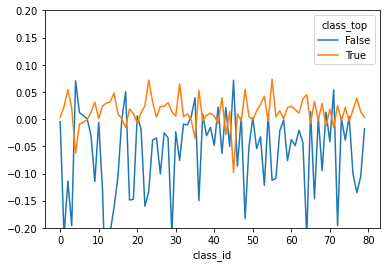

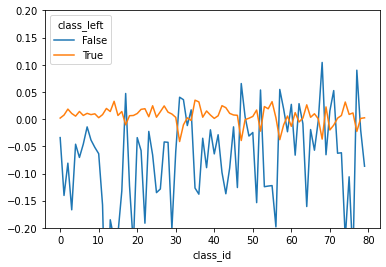

In [17]:
mean_class_acc = merged.groupby(["class_id"]).apply(get_class_acc).groupby(["class_id"]).mean()["acc"]

horizontal_top.unstack(level=0).apply(lambda x: x-mean_class_acc, axis=1).T.plot()
plt.ylim(-0.20, 0.20)
plt.show()

# only necessary when not using the class centroid
#horizontal_bottom.unstack(level=0).apply(lambda x: x-mean_class_acc, axis=1).T.plot()
#plt.ylim(-0.20, 0.20)
#plt.show()

vertical_left.unstack(level=0).apply(lambda x: x-mean_class_acc, axis=1).T.plot()
plt.ylim(-0.20, 0.20)
plt.show()

# only necessary when not using the class centroid
#vertical_right.unstack(level=0).apply(lambda x: x-mean_class_acc, axis=1).T.plot()
#plt.ylim(-0.20, 0.20)
#plt.show()

# Open questions:
* No Appendix in the paper, eventhough is referenced multiple times (is this journal specific?)
* Table 2: Position with regards to all possible centroids or is there a grid?
* Table 2: Angle somewhat divided in intervals?
* "combined center of mass": is that weighted mean/sum? Why should this make sense?
* Only public Randomized conditional Correlation Test (RCOT) implementation is in R (https://github.com/ericstrobl/RCIT/blob/master/R/RCoT.R)